In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical


df = pd.read_csv("../../data/csv/cleaned_fix.csv")
selected_columns = ["Image", "Scene", "ROI", "FixDur", "FixNr", "Start", "End", "X", "Y", "Participant", "experience"]
df_filtered =  df[selected_columns]

2025-06-23 17:01:22.683591: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-23 17:01:24.466822: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750690884.975145 1943949 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750690885.126997 1943949 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750690886.237380 1943949 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
df_filtered.sort_values(by=['Participant', 'FixNr'], inplace=True)

/tmp/ipykernel_1943949/4086940616.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.sort_values(by=['Participant', 'FixNr'], inplace=True)


In [3]:
# --- Encode labels ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_filtered['Participant'])  # 'Label' should be your column with categories
y_onehot = to_categorical(y_encoded)

# --- Normalize features ---
features = df_filtered.drop(columns=['Participant', 'experience'])  # adjust based on your data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [4]:
# --- Sliding window function ---
def create_sequences(X, y, window_size):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size - 1])  # predict last item in window
    return np.array(X_seq), np.array(y_seq)

In [5]:
window_size = 5  # adjust as needed
X_seq, y_seq = create_sequences(X_scaled, y_onehot, window_size)

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [6]:
# --- LSTM Model ---
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(36, activation='softmax')  # 4 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- Train ---
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.1)

W0000 00:00:1750690899.108230 1943949 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/sam/anaconda3/envs/thesis/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
678/678 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0934 - loss: 3.2926 - val_accuracy: 0.2754 - val_loss: 2.5046
Epoch 2/200
678/678 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3114 - loss: 2.3576 - val_accuracy: 0.3762 - val_loss: 2.1038
Epoch 3/200
678/678 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3748 - loss: 2.0728 - val_accuracy: 0.4069 - val_loss: 1.9306
Epoch 4/200
678/678 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4242 - loss: 1.8981 - val_accuracy: 0.4334 - val_loss: 1.8349
Epoch 5/200
678/678 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4563 - loss: 1.7788 - val_accuracy: 0.4504 - val_loss: 1.7552
Epoch 6/200
678/678 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4809 - loss: 1.6883 - val_accuracy: 0.4670 - val_loss: 1.7263
Epoch 7/200
678/678 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5163 - loss: 1.5933 - val_accuracy: 0.5052 - val_loss: 1.5767
Epoch 8/200
678/678 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5387 - loss: 1.5083 - val_accu

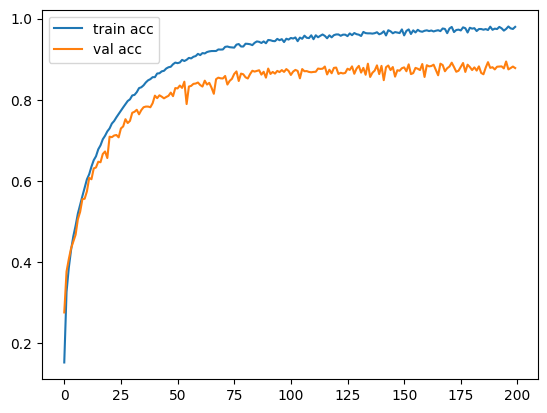

In [7]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [8]:
# --- Evaluate ---
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - accuracy: 0.8657 - loss: 0.7561
Test Accuracy: 0.86


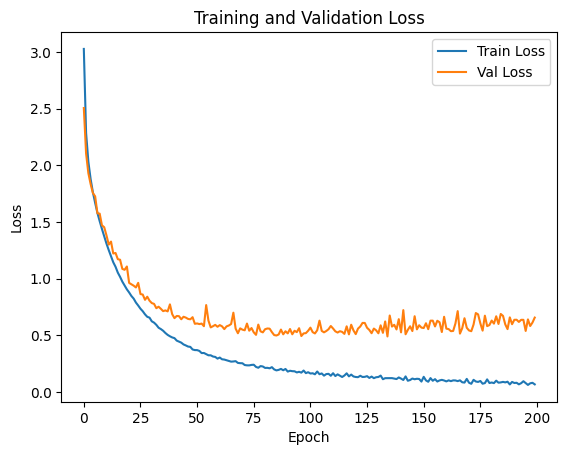

In [9]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step


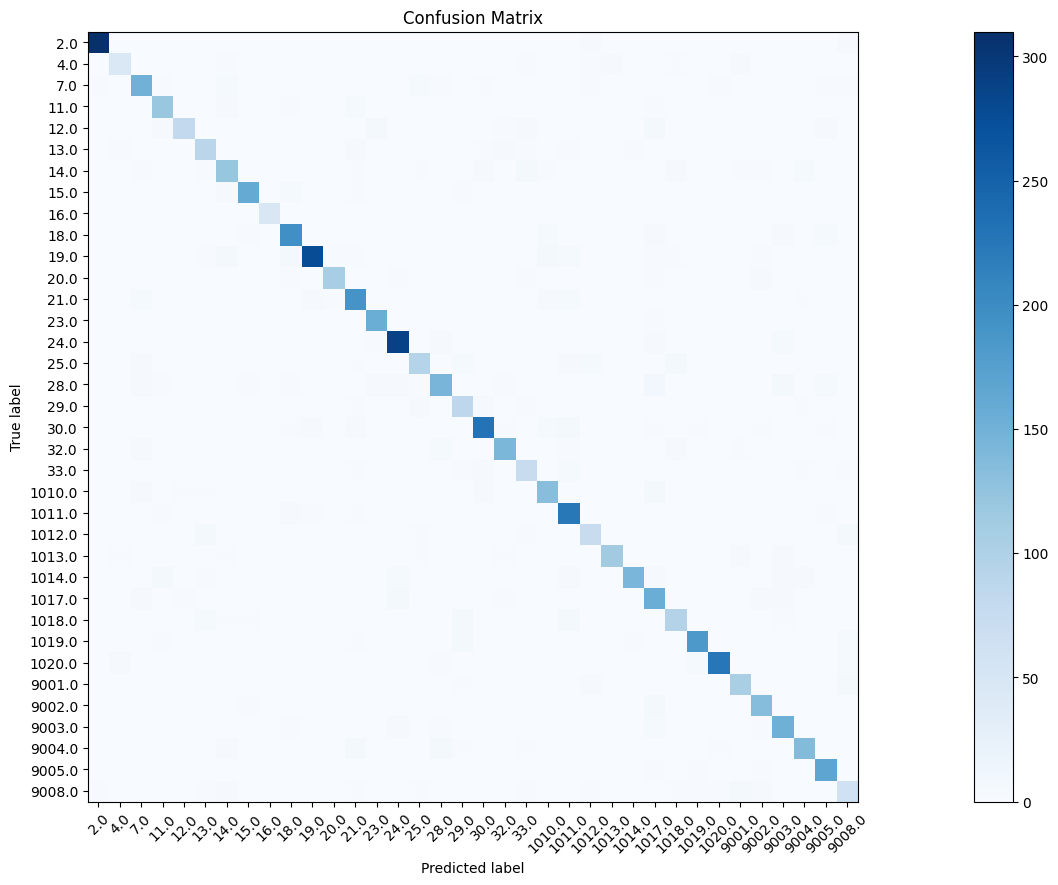

In [26]:
# --- Predict on test set ---
y_pred_probs = model.predict(X_test)                     # Get prediction probabilities
y_pred = np.argmax(y_pred_probs, axis=1)                 # Convert to class indices
y_true = np.argmax(y_test, axis=1)                       # Convert one-hot to class indices

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# Plot without numbers and larger figure
fig, ax = plt.subplots(figsize=(30, 10))  # Increase size (adjust as needed)
disp.plot(cmap=plt.cm.Blues, ax=ax, include_values=False)  # values_format='' removes the numbers
plt.title('Confusion Matrix')
ax.tick_params("x", rotation=45)
plt.show()


In [11]:
# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       317
           1       0.81      0.69      0.74        67
           2       0.85      0.82      0.84       182
           3       0.81      0.87      0.84       139
           4       0.88      0.76      0.82       106
           5       0.77      0.81      0.79       108
           6       0.80      0.77      0.79       158
           7       0.90      0.90      0.90       178
           8       1.00      0.98      0.99        48
           9       0.86      0.91      0.88       215
          10       0.95      0.87      0.90       319
          11       0.91      0.88      0.90       121
          12       0.82      0.89      0.85       214
          13       0.92      0.96      0.94       161
          14       0.91      0.95      0.93       303
          15       0.81      0.76      0.78       124
          16       0.87      0.78      0.82       187
    